In [187]:
# Работы с текстом
import nltk
# nltk.download('punkt')

# Алгоритмы кластеризации
from sklearn.cluster import KMeans

# Алгоритмы уменьшения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Для построения TaggedDocuments для  Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import doc2vec

# Работа с данным 
import numpy as np
import pandas as pd

# Визуализация
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

## Хакатон

https://www.kaggle.com/c/ai-hackathon-2018-spb-gpn/data

Вдохновение

https://habrahabr.ru/article/318160/

## Загрузка данных и создание листа с текстами товаров

In [188]:
documents = pd.read_csv("../data/data_for_doc2vec.csv", sep=',', encoding='utf-8')
documents_goods = documents["goods_sentence"].tolist()

In [189]:
documents.head()

,id,goods_sentence
0,21-8B2-7695,164 128 126 126 233 150 128 233 126 126 126 233
1,21-8B2-7693,203 126 233 126 128 128 126 128 128 146 128 12...
2,21-8B2-7688,203 128
3,21-8B2-7685,126 126 128 126 164 126 126 126
4,21-8B2-7683,128 126 126 128 126 132 126 128 128 126 126 12...


#### Разбиваю тексты с покупками на отдельные покупки для каждого пользователя

In [171]:
cg = pd.concat([pd.Series(row['id'], row['goods_sentence'].split(' '))              
                    for _, row in documents.iterrows()]).reset_index()

In [172]:
cg.columns = ["index", "ids"]
cg = cg.drop_duplicates(['index', 'ids'])

In [173]:
cg.head()

,index,ids
0,233,21-8B2-7695
1,150,21-8B2-7695
2,154,21-8B2-7693
3,202,21-8B2-7693
4,134,21-8B2-7683


#### Создаем список уникальных пользователей

In [174]:
users = list(set(cg["ids"]))

### Обучение

In [175]:
import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO 

### Токенизация текстов

In [176]:
goods_sentences = [nltk.word_tokenize(doc) for doc in documents_goods]

In [177]:
# построение листа с туплами ("коды", "id клиента")
all_ids = list(zip(goods_sentences, documents["id"]))
# документы для vord2veca | Warning! Class will be removed in 4.0.0, use TaggedDocument instead!
labeld_objects = [TaggedDocument(words = i[0], tags = [i[1]]) for i in all_ids]

In [178]:
# обучение Doc2veca 
doc2vec_model = doc2vec.Doc2Vec(labeld_objects, min_count=1);

INFO : collecting all words and their counts
INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO : PROGRESS: at example #10000, processed 174820 words (337120/s), 192 word types, 10000 tags
INFO : PROGRESS: at example #20000, processed 339661 words (2203178/s), 204 word types, 20000 tags
INFO : PROGRESS: at example #30000, processed 508213 words (2105879/s), 222 word types, 30000 tags
INFO : PROGRESS: at example #40000, processed 644587 words (1953144/s), 225 word types, 40000 tags
INFO : PROGRESS: at example #50000, processed 1010106 words (3050870/s), 246 word types, 50000 tags
INFO : PROGRESS: at example #60000, processed 1297006 words (3313721/s), 255 word types, 60000 tags
INFO : collected 256 word types and 69555 unique tags from a corpus of 69555 examples and 1373857 words
INFO : Loading a fresh vocabulary
INFO : min_count=1 retains 256 unique words (100% of original 256, drops 0)
INFO : min_count=1 leaves 1373857 word corpus (100% of original 1373

In [179]:
# Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead
docs_vectors = pd.DataFrame(doc2vec_model.docvecs.vectors_docs)

## Уменьшение размерности

TSNE преобразование

In [191]:
tsne = TSNE(n_components=2, random_state = 12)
X_tsne1 = tsne.fit_transform(docs_vectors.iloc[:5000,:])

Анализ главных компонент

In [181]:
pca = PCA(n_components = 2, random_state = 12)
X_pca1 = pca.fit_transform(docs_vectors.iloc[:5000, :])

## Кластеризация

K-means

In [182]:
kmeans = KMeans(n_clusters = 10, random_state=12)
dannie = kmeans.fit(docs_vectors.iloc[:5000,:])

## Визуализация кластеров

In [183]:
# индексы датафрейма
user = corpus["id"].tolist()[:5000]

In [184]:
docf = pd.DataFrame(X_tsne1, index=user, columns=['x', 'y'])
docf_pca = pd.DataFrame(X_pca1, index = user, columns=["x", "y"])


# колокна принадлежности к классам выделенным k-means
docf["clust"] = kmeans.labels_
docf_pca["clust"] = kmeans.labels_

docf.head()

,x,y,clust
21-8B2-7695,-32.262463,14.026436,3
21-8B2-7693,4.102086,-56.051716,1
21-8B2-7688,6.949825,-73.003914,9
21-8B2-7685,-27.205400,-32.892887,7
21-8B2-7683,-10.697948,-61.414585,9


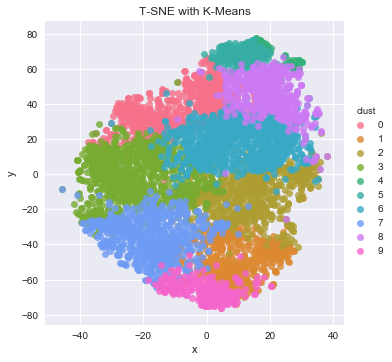

In [185]:
sns.set(rc={'figure.figsize':(12,8)})
sns.lmplot("x", "y", data= docf, hue = 'clust', fit_reg=False)
plt.title("T-SNE with K-Means");
plt.savefig('myimage.png', format='png', dpi=1200)

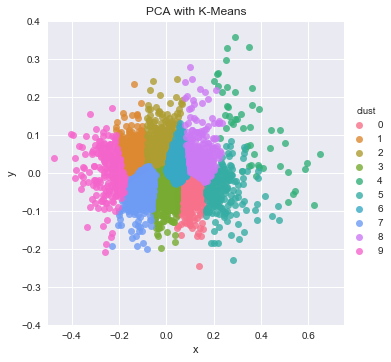

In [186]:
sns.lmplot("x", "y", data = docf_pca, hue = "clust", fit_reg = False)
plt.ylim(-0.4, 0.4)
plt.xlim(-0.5, 0.75)
plt.title("PCA with K-Means");